# Gradient-based Variational Inference in a Simple Gaussian Model

This notebook looks at the same simple setting as the previous one: variational inference in a simple Gaussian model. However, rather than using _coordinate ascent_ variational inference, we'll _gradient based_ variational inference. 

CAVI is great, but is most practical in simple models with exponential family distributions and conjugate priors. In those settings, the coordinate updates have simple, closed forms. However, it's nice to have more general methods in our toolkit too; ones that work on a wider range of models. 

Just like Hamiltonian Monte Carlo can be used on any model with continuous latent variables and a differentiable log joint probability, gradient-based variational inference methods like **automatic differentiation variational inference (ADVI)** can be used in the same settings. And just like CAVI can provide lower variance (albeit asymptotically biased) estimates than Gibbs sampling for the same computational budget, ADVI can have the same advantage over HMC.

Here, we'll develop ADVI for the simple Gaussian model from Lecture 1 and contrast it with the CAVI algorithm from the previous notebook.

**Notation:** Again, let,
- $x_n \in \mathbb{R}$ denote the $n$-th data point,
- $\mu \in \mathbb{R}$ denote the unknown mean of the distribution, and
- $\sigma^2 \in \mathbb{R}_+$ denote the unknown variance of the distribution.
- $\mu_0, \kappa_0, \nu_0, \sigma_0^2$ denote the hyperparameters of a NIX prior on $(\mu, \sigma^2)$.

**Model:**

$$
\begin{align*}
\sigma^2 &\sim \chi^{-2}(\nu_0, \sigma_0^2) \\
\mu \mid \sigma^2 &\sim \mathcal{N}(\mu_0, \kappa_0^{-1} \sigma^2) \\
x_n \mid \mu, \sigma^2 &\sim \mathcal{N}(\mu, \sigma^2)  \quad  \text{for } n =1, \ldots, N
\end{align*}
$$

In [1]:
import torch
from torch.distributions import Normal, Gamma, StudentT, TransformedDistribution, LogNormal
from torch.distributions.transforms import PowerTransform
from torch import nn 
import torch.nn.functional as F
from torch.optim import Adam, SGD
torch.manual_seed(305)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

## Helper functions

The following cells implement the `ScaledInvChiSq` distribution and a simple plotting function.

In [2]:
class ScaledInvChiSq(TransformedDistribution):
    """
    Implementation of the scaled inverse \chi^2 distribution defined in class.
    We will implement it as a transformation of a gamma distribution.
    """
    def __init__(self, dof, scale):
        base = Gamma(dof / 2, dof * scale / 2)
        transforms = [PowerTransform(-1)]
        TransformedDistribution.__init__(self, base, transforms)
        self.dof = dof
        self.scale = scale

In [3]:
# Evaluate the density on a grid
def plot_nix(mu_N, kappa_N, nu_N, sigmasq_N, q_mu=None, q_sigmasq=None,
             mu_min=-2, mu_max=0, sigmasq_min=1, sigmasq_max=4, title=""):
    
    # Make a grid of mu and sigmasq values
    mus = torch.linspace(mu_min, mu_max, 50)
    sigmasqs = torch.linspace(sigmasq_min, sigmasq_max, 50)
    mu_grid, sigmasq_grid = torch.meshgrid(mus, sigmasqs)
    
    # Compute the true log probability
    true_log_prob = ScaledInvChiSq(nu_N, sigmasq_N).log_prob(sigmasq_grid)
    true_log_prob += Normal(mu_N, torch.sqrt(sigmasq_grid / kappa_N)).log_prob(mu_grid)
    
    # Compute the true marginals
    sigmasq_marginal = ScaledInvChiSq(nu_N, sigmasq_N)
    mu_marginal = StudentT(nu_N, mu_N, torch.sqrt(sigmasq_N / kappa_N))

    # Start with a square Figure.
    fig = plt.figure(figsize=(6, 6))
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.1, hspace=0.1)
    
    ax_j = fig.add_subplot(gs[1, 0])
    ax_j.contourf(mu_grid, sigmasq_grid, torch.exp(true_log_prob), 10)
    ax_j.set_xlim(mu_min, mu_max)
    ax_j.set_ylim(sigmasq_min, sigmasq_max)
    ax_j.set_xlabel("$\mu$")
    ax_j.set_ylabel("$\sigma^2$")
    # ax_j.set_title("joint distribution")
    
    ax_mu = fig.add_subplot(gs[0,0], sharex=ax_j)
    ax_mu.plot(mus, torch.exp(mu_marginal.log_prob(mus)))
    # ax_mu.set_title(r"$\mu$ marginal")
    plt.setp(ax_mu.get_xticklabels(), visible=False)
    
    ax_sig = fig.add_subplot(gs[1,1], sharey=ax_j)
    ax_sig.plot(torch.exp(sigmasq_marginal.log_prob(sigmasqs)), sigmasqs)
    # ax_sig.set_title(r"$\sigma^2$ marginal")
    plt.setp(ax_sig.get_yticklabels(), visible=False)
    
    # If variational posterior is given, plot its joint and marginals
    if q_mu is not None and q_sigmasq is not None:
        var_log_prob = q_sigmasq.log_prob(sigmasq_grid)
        var_log_prob += q_mu.log_prob(mu_grid)
        ax_j.contour(mu_grid, sigmasq_grid, torch.exp(var_log_prob).detach().numpy(), 
                     10, colors='r', linewidths=1)

        ax_mu.plot(mus, torch.exp(q_mu.log_prob(mus)).detach().numpy(), color='r', ls='--')
        ax_sig.plot(torch.exp(q_sigmasq.log_prob(sigmasqs)).detach().numpy(), sigmasqs, color='r', ls='--')

    plt.suptitle(title)
    return fig
    

In [4]:
# Set NIX hypers
mu0 = torch.tensor(0.)
kappa0 = torch.tensor(1.0)
nu0 = torch.tensor(2.0)
sigmasq0 = torch.tensor(2.0)

# Sample from the model
N = 20
sigmasq = ScaledInvChiSq(nu0, sigmasq0).sample()
mu = Normal(mu0, torch.sqrt(sigmasq / kappa0)).sample()
X = Normal(mu, torch.sqrt(sigmasq)).sample(sample_shape=(N,))
print("mean X: ", X.mean())
print("var X: ", X.var())

# Compute the posterior
nu_N = nu0 + N
kappa_N = kappa0 + N
mu_N = 1/kappa_N * (kappa0 * mu0 + X.sum())
sigmasq_N = 1/nu_N * (nu0 * sigmasq0 + kappa0 * mu0**2 + torch.sum(X**2) - kappa_N * mu_N**2)
print("E[mu | X]:      ", mu_N)
print("E[sigmasq | X]: ", sigmasq_N * (nu_N / (nu_N + 2)))

mean X:  tensor(-0.9374)
var X:  tensor(2.3735)
E[mu | X]:       tensor(-0.8927)
E[sigmasq | X]:  tensor(2.0805)


/Users/scott/miniconda3/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


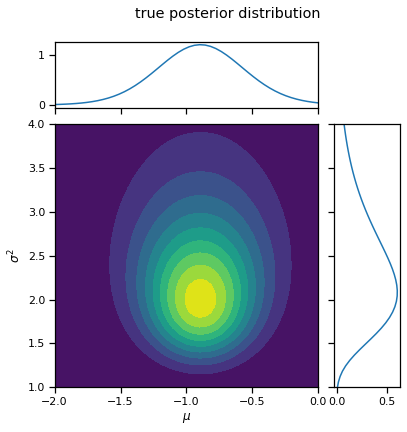

In [5]:
_ = plot_nix(mu_N, kappa_N, nu_N, sigmasq_N, title="true posterior distribution")

## Approximate the posterior with VI

Like with CAVI, we will approximate the posterior by minimizing the KL divergence between a variational posterior, $q(\mu, \sigma^2)$, and the true posterior, $p(\mu, \sigma^2 \mid X)$. Unlike CAVI, we will assume a fixed form of the distribution. For example, assume the variational posterior is of the form,

$$
\begin{align*}
q(\mu, \sigma^2) &= \mathcal{N}(\mu \mid \widetilde{\mu}, \widetilde{v}) \times
\mathrm{LN}(\sigma^2 \mid \widetilde{\alpha}, \widetilde{\beta}) \\
\end{align*}
$$

where $\mathrm{LN}$ denotes the [**log-normal distribuion**](https://en.wikipedia.org/wiki/Log-normal_distribution). The parameters $\widetilde{\alpha}$ and $\widetilde{\beta}$ specify the mean and variance, respectively, of $\log \sigma^2$.

Let $\lambda = (\widetilde{\mu}, \widetilde{v}, \widetilde{\alpha}, \widetilde{\beta})$ denote the variational parameters. Out goal is to find variational parameters that minimize the KL divergence, $\mathrm{KL}(q(\mu, \sigma^2) \, \|\, p(\mu, \sigma^2 \mid X))$, or, equivalently, maximize the **evidence lower bound (ELBO)**:

$$
\begin{align*}
\mathcal{L}(\lambda) &=
\mathbb{E}_{q(\mu, \sigma^2; \lambda)}\left[ \log p(X, \mu, \sigma^2) - \log q(\mu, \sigma^2; \lambda) \right].
\end{align*}
$$

This time, we'll perform that optimization via **stochastic gradient descent (SGD)** on the (negative) ELBO.

### Maximizing the ELBO via stochastic gradient ascent

The challenge is that usually, the ELBO can't be computed exactly. It's an expectation with respect to $q$, and typically that expectation won't have an analytical form. (We can only evaluate the ELBO exactly in special cases, like models built from exponential family distributions and conjugate priors.) Since we can't evaluate the ELBO exactly, we can't evaluate its gradient exactly either.

Instead, we'll compute an unbiased estimate of the ELBO and its gradient. It's easy enough to compute an Monte Carlo estimate of the ELBO,

$$
\begin{align*}
\hat{\mathcal{L}}(\lambda) &=
\frac{1}{M} \sum_{m=1}^M \log p(X, \mu_m, \sigma^2_m) - \log q(\mu_m, \sigma^2_m; \lambda) \quad 
\text{where} \quad  \mu_m, \sigma^2_m \sim q(\mu, \sigma^2; \lambda).
\end{align*}
$$

To perform stochastic gradient ascent, we need an unbiased estimate of the **gradient** of the ELBO, $\nabla_\lambda \mathcal{L}(\lambda)$.  Obtaining such an estimate is not quite as easy. The problem is that we cannot simply pass the gradient inside the expectation,

$$
\begin{align*}
\nabla_\lambda \hat{\mathcal{L}}(\lambda) &\textcolor{red}{\neq}
\mathbb{E}_{q(\mu, \sigma^2; \lambda)}\left[ \log p(X, \mu, \sigma^2) - \nabla_\lambda \log q(\mu, \sigma^2; \lambda) \right].
\end{align*}
$$

The expectation is taken with respect to $q(\mu, \sigma^2; \lambda)$, so we have to account for how perturbations of $\lambda$ affect $q$, which in turn alter the expectation. 

## The reparameterization trick

There are a few ways of obtaining an unbiased estimate of the gradient. One approach is the **reparameterization trick.** In this case, we can rewrite samples of $q(\mu, \sigma^2)$ as _determinisitic transformations of independent, standard normal random variables_,

$$
\begin{align*}
\mu, \sigma^2 \sim q(\mu, \sigma^2) \iff
\mu &= \mu(\epsilon_1, \lambda) \triangleq \widetilde{\mu} + \sqrt{\widetilde{v}} \epsilon_1 & 
\epsilon_1 &\sim \mathcal{N}(0, 1) \\
\sigma^2 &= \sigma^2(\epsilon_2, \lambda) \triangleq \exp \left\{\widetilde{\alpha} + \sqrt{\widetilde{\beta}} \epsilon_2 \right\} & 
\epsilon_2 &\sim \mathcal{N}(0, 1) \\
\end{align*}
$$

Then, appealing to the [**law of the unconscious statistician**](https://en.wikipedia.org/wiki/Law_of_the_unconscious_statistician), we can rewrite the ELBO as an expectation with respect to $\boldsymbol{\epsilon} = (\epsilon_1, \epsilon_2)$,

$$
\begin{align*}
\mathcal{L}(\lambda) &=
\mathbb{E}_{\boldsymbol{\epsilon} \sim \mathcal{N}(0,I)}\left[ \log p(X, \mu(\epsilon_1, \lambda), \sigma^2(\epsilon_2, \lambda)) - \log q(\mu(\epsilon_1, \lambda), \sigma^2(\epsilon_2, \lambda); \lambda) \right].
\end{align*}
$$

Now the expectation is taken with respect to a distribution that does not depend on $\lambda$! That means we can pass the gradient inside the expectation and estimate it with ordinary Monte Carlo, just like the ELBO above.


$$
\begin{align*}
\hat{\nabla}_\lambda \mathcal{L}(\lambda) &=
\frac{1}{M} \sum_{m=1}^M \nabla_\lambda \left[ \log p(X, \mu(\epsilon_{m,1}, \lambda), \sigma^2(\epsilon_{m,2}, \lambda)) - \log q(\mu(\epsilon_{m,1}, \lambda), \sigma^2(\epsilon_{m,2}, \lambda); \lambda)  \right] \quad 
\end{align*}
$$

where $\boldsymbol{\epsilon}_m \sim \mathcal{N}(0, I)$.

### Question

Aside from being able to "reparameterize" $q$, what assumptions are necessary for this approach? Can $(\mu, \sigma^2)$ be discrete? Must $q$ and $p$ be differentiable?

## Let's implement it!

Now let's see how gradient-based VI works in code!

In [6]:
class VariationalPosterior(nn.Module):
    """We instantiate the variational posterior as a PyTorch Module.
    This base class makes it easy to optimize the parameters of the
    posterior ($\lambda$).
    
    """
    
    def __init__(self, mu0, kappa0, nu0, sigmasq0):
        super().__init__()
        
        # Store the hyperparameters
        self.mu0 = mu0
        self.kappa0 = kappa0
        self.nu0 = nu0
        self.sigmasq0 = sigmasq0

        # Initialize the parameters of the variational posterior
        # NOTE: We use unconstrained variance parameters for optimization
        self.mu_tilde = nn.Parameter(torch.tensor(0.0))
        self.unc_v_tilde = nn.Parameter(torch.tensor(0.0))
        self.alpha_tilde = nn.Parameter(torch.tensor(0.0))
        self.unc_beta_tilde = nn.Parameter(torch.tensor(0.0))
        
    @property
    def q_mu(self):
        # Note the use of softplus 
        return Normal(self.mu_tilde, torch.sqrt(F.softplus(self.unc_v_tilde)))
    
    @property
    def q_sigmasq(self):
        # Note the use of softplus 
        return LogNormal(self.alpha_tilde, torch.sqrt(F.softplus(self.unc_beta_tilde)))
    
    def forward(self, X, num_samples=1):
        """Compute an unbiased estimate of the ELBO using reparameterized
        samples of the variational posterior.
        """
        # Sample the variational posterior using the reparameterization trick
        # NOTE THE USE of `rsample`!
        mus = self.q_mu.rsample((num_samples,))
        sigmasqs = self.q_sigmasq.rsample((num_samples,))
        sigmas = torch.sqrt(sigmasqs)
        
        # Compute a Monte Carlo estimate of the ELBO
        # log \sum_n p(x_n | \mu_m, \sigmasq_m)
        elbo = Normal(mus[:, None], sigmas[:, None]).log_prob(X[None, :]).sum(axis=1)
        # log p(\sigma^2 | \nu_0, \sigma_0^2)
        elbo += ScaledInvChiSq(self.nu0, self.sigmasq0).log_prob(sigmasqs)
        # log p(\mu | \mu_0, \sigma^2 / kappa_0)
        elbo += Normal(self.mu0, sigmas / torch.sqrt(self.kappa0)).log_prob(mus)
        # -log q(\mu)
        elbo -= self.q_mu.log_prob(mus)
        # -log q(\sigma^2)
        elbo -= self.q_sigmasq.log_prob(sigmasq)
        
        # Return the mean over the Monte Carlo samples
        assert elbo.shape == (num_samples,)
        return elbo.mean()

### Maximize the ELBO

In [7]:
posterior = VariationalPosterior(mu0, kappa0, nu0, sigmasq0)
# optimizer = Adam(posterior.parameters(), lr=0.001)
optimizer = SGD(posterior.parameters(), lr=0.001, momentum=0.9)

elbos = []
num_iters = 5000
save_every = 100
for itr in range(num_iters+1):
    optimizer.zero_grad()
    elbo = posterior(X, num_samples=10)
    loss = -elbo / N        # negate and rescale the elbo to get the loss
    loss.backward()
    optimizer.step()
    
    # Store ELBO and params
    elbos.append(elbo.detach().numpy())
    
    if itr % save_every == 0:
        torch.save(posterior.state_dict(), "step_{:04d}.pt".format(itr))

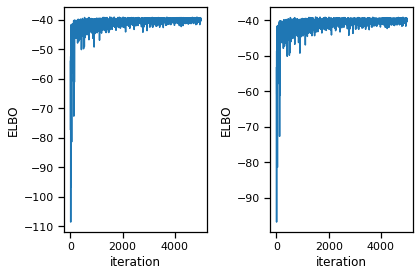

In [8]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(elbos)
axs[0].set_xlabel("iteration")
axs[0].set_ylabel("ELBO")

axs[1].plot(elbos[10:])
axs[1].set_xlabel("iteration")
axs[1].set_ylabel("ELBO")
# axs[1].set_ylim(bottom=elbos[10])

plt.tight_layout()


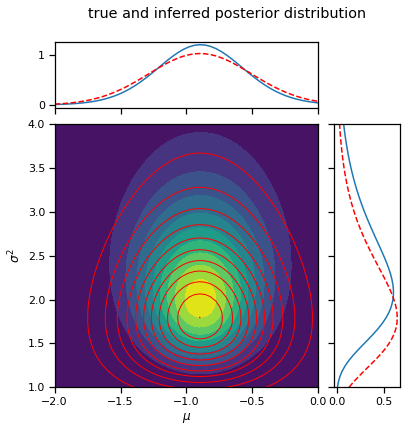

In [9]:
_ = plot_nix(mu_N, kappa_N, nu_N, sigmasq_N, 
             q_mu=posterior.q_mu, q_sigmasq=posterior.q_sigmasq,
             title="true and inferred posterior distribution")

In [10]:
# Plot the posterior over the course of SGD iterations
for itr in range(0, num_iters+1, save_every):
    posterior.load_state_dict(torch.load("step_{:04d}.pt".format(itr)))
    fig = plot_nix(mu_N, kappa_N, nu_N, sigmasq_N, 
                   q_mu=posterior.q_mu, q_sigmasq=posterior.q_sigmasq,
                   title="step {}".format(itr))
    
    fig.savefig("step_{:04d}.png".format(itr))
    plt.close(fig)

In [11]:
!convert -delay 100 -loop 0 `ls -v step_*.png` advi_nix.gif
!rm step_*.png
!rm step_*.pt

![advi_nix](./advi_nix.gif)